In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [8]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Оценим модель на основе логистической регресии

In [9]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_lr_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [10]:
preds_lr = classifier.predict_proba(X_test)[:, 1]
preds_lr

array([0.21919629, 0.24759828, 0.40484498, ..., 0.16941878, 0.70519218,
       0.75098778])

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_lr= np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_lr], 
                                                                        fscore[ix_lr],
                                                                        precision[ix_lr],
                                                                        recall[ix_lr]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


In [46]:
recall[ix_lr]

0.8375576036866359

In [12]:
roc_auc_lr=roc_auc_score(y_test, preds_lr)
roc_auc_lr

0.7840347790421852

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


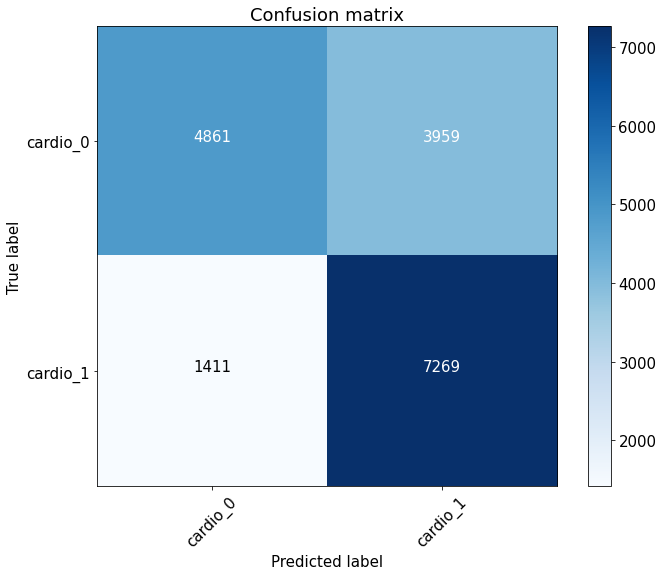

In [13]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_lr_score>thresholds[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

In [14]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

Теперь оценим класификацию на основе бустинга

In [15]:
classifier_gb = Pipeline([
    ('features',feats),
    ('classifier_gb', GradientBoostingClassifier(n_estimators=200, random_state=42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_gb_score = classifier_gb.predict_proba(X_test)[:, 1]

CV score is 0.8025425780743596+-0.007047121722030907


In [16]:
preds_gb = classifier_gb.predict_proba(X_test)[:, 1]
preds_gb

array([0.15462197, 0.19208147, 0.35951164, ..., 0.11929698, 0.74176718,
       0.77467317])

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_gb= np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_gb], 
                                                                        fscore[ix_gb],
                                                                        precision[ix_gb],
                                                                        recall[ix_gb]))

Best Threshold=0.388025, F-Score=0.740, Precision=0.693, Recall=0.794


In [18]:
roc_auc_gb=roc_auc_score(y_test, preds_gb)
roc_auc_gb

0.8028766053272308

Confusion matrix, without normalization
[[5770 3050]
 [1789 6891]]


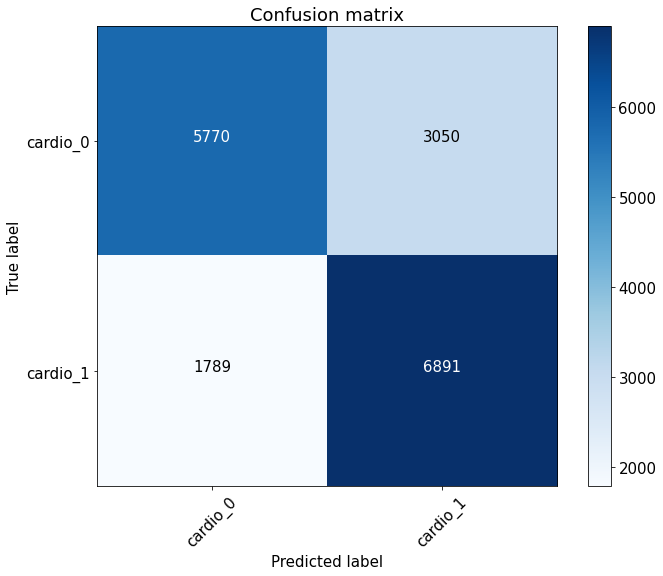

In [19]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_gb_score>thresholds[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

In [20]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7938940092165898, 0.3458049886621315, 0.6541950113378685)

Построим класификацию на основе случайного леса.

In [21]:
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier_rf', RandomForestClassifier(
n_estimators=300, max_depth=50, random_state=42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_rf_score = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7755578817069755+-0.007721860624953121


In [22]:
preds_rf = classifier_rf.predict_proba(X_test)[:, 1]
preds_rf

array([0.26722222, 0.18666667, 0.03804878, ..., 0.05      , 0.76666667,
       0.74333333])

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_rf= np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_rf], 
                                                                        fscore[ix_rf],
                                                                        precision[ix_rf],
                                                                        recall[ix_rf]))

Best Threshold=0.363939, F-Score=0.721, Precision=0.655, Recall=0.803


In [24]:
roc_auc_rf=roc_auc_score(y_test, preds_rf)
roc_auc_rf

0.7725607973604187

Confusion matrix, without normalization
[[5141 3679]
 [1711 6969]]


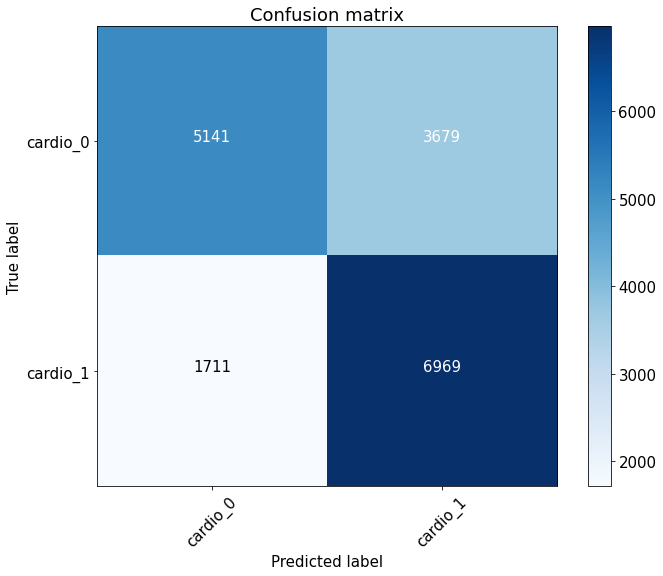

In [25]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_rf_score>thresholds[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

In [26]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8028801843317972, 0.4171201814058957, 0.5828798185941043)

In [47]:
model=("LogisticRegression", "GradientBoostingClassifier", "RandomForestClassifier")
df_total= pd.DataFrame({'model':model,
                        'Roc_auc':[roc_auc_lr, roc_auc_gb, roc_auc_rf],
                        'F-score':[fscore[ix_lr],fscore[ix_gb],fscore[ix_rf]],
                        'Precision':[precision[ix_lr],precision[ix_gb],precision[ix_rf]],
                        'Recall':[recall[ix_lr],recall[ix_gb],recall[ix_rf]]})
df_total.style.hide_index().format({'Roc_auc': "{:.3}", 'F-score': "{:.3}",'Precision': "{:.3}",'Recall': "{:.3}"})

model,Roc_auc,F-score,Precision,Recall
LogisticRegression,0.784,0.73,0.647,0.838
GradientBoostingClassifier,0.803,0.727,0.625,0.868
RandomForestClassifier,0.773,0.67,0.506,0.991


4. Сделать выводы о том, какая модель справилась с задачей лучше других
Если сравнивать в лоб по Бустинг явно лочшею.Но в контексте задачи мне кажетсья, 
больше подходит случайны лес в нем мы существенно снижаем поток поток поциентов 
у ктороых нет ССЗ, при это незначительно падает поток действительно больных.


5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

 Мне кажетсья precision_recall_curve подходит лучше при определенной инторпритации. Так как мы можем подстроить моджель под опреденный класс, если други для нас не занчимы.  